## Processing Safegraph Mobily Data and Converting it to a tensor and matrix

### Preparing Real-World Mobility Data and converting it to a Tensor and Matrix

- Processing and binning mobility data
- Converting binned mobility data into tensor and matrix

In [1]:
import numpy as np
import pandas as pd
import xarray
import tensorly as tl

In [2]:
# download geopandas before running
import geopandas as gpd
from shapely.geometry import Point

In [3]:
# datetime
import datetime

In [4]:
# load data into DataFrame
df_path = "mobility_data_merged.csv"
df = pd.read_csv(df_path)

In [5]:
df

,poi_cbg,dt,week,raw_visit_counts,dist_to_fire_m,poi_cnt,pop2019
0,60290033051,2018-12-31,1,172,26615.418910,51,1393
1,60290033051,2019-01-07,2,329,26615.418910,51,1393
2,60290033051,2019-01-14,3,244,26615.418910,51,1393
3,60290033051,2019-01-21,4,313,26615.418910,51,1393
4,60290033051,2019-01-28,5,274,26615.418910,51,1393
...,...,...,...,...,...,...,...
986273,61110085003,2021-06-07,23,6901,8958.938209,477,3340
986274,61110085003,2021-06-14,24,6997,8958.938209,477,3340
986275,61110085003,2021-06-21,25,7166,8958.938209,477,3340
986276,61110085003,2021-06-28,26,6934,8958.938209,477,3340


### Adjusting mobility data
- tensor modes: cbg_id, month #, week #
    - Only around 500 cbg_id around central LA
    - Normalized coordinates scaled between 0 and 1, take their average
- matrix modes: same cbg_id and pop2019, poi_cnt

In [6]:
# Add GEOID to df (only run once so not too many zeros are added)

for i in range(0, len(df)):
    if (str(df.at[i,'poi_cbg'])[0] != '0'):
        df.at[i,'poi_cbg'] = "0" + str(df.at[i,'poi_cbg'])

In [7]:
geo_df = gpd.read_file('la_fire_cbg_30000m.geojson', dtype={'GEOID':'str'})

In [8]:
geo_df.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,111,007506,5,061110075065,Block Group 5,G5030,S,469020,15988,+34.2526098,-118.7395930,"MULTIPOLYGON (((-118.74496 34.25722, -118.7445..."
1,06,065,030104,2,060650301042,Block Group 2,G5030,S,858394,0,+33.9993465,-117.3660904,"MULTIPOLYGON (((-117.37605 34.00218, -117.3760..."
2,06,065,031501,5,060650315015,Block Group 5,G5030,S,233796,0,+33.9331513,-117.4280261,"MULTIPOLYGON (((-117.43166 33.93288, -117.4313..."
3,06,111,007512,2,061110075122,Block Group 2,G5030,S,925075,51577,+34.2580996,-118.7381322,"MULTIPOLYGON (((-118.74388 34.26011, -118.7438..."
4,06,037,187200,2,060371872002,Block Group 2,G5030,S,543859,8150,+34.1069009,-118.2493596,"MULTIPOLYGON (((-118.25704 34.10773, -118.2566..."


#### Narrow down to 500 CBG_ID around Central Los Angeles

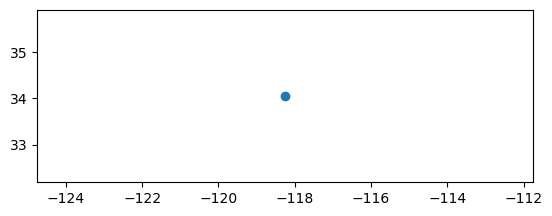

In [15]:
from shapely.geometry import Point

# Circle to define geographic boundaries around LA
LA_lat, LA_lon = 34.0522, -118.2437 # LA coordinates

point_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[Point(LA_lon, LA_lat)])
point_gdf.plot()

point_gdf = point_gdf.to_crs("EPSG:3857")

In [16]:
print(point_gdf.geometry[0])

POINT (-13162828.473512601 4035813.3662658855)


In [73]:
# Change from geographic CRS to projected CRS for more accuracy to calculate distance
#LA_shp = LA_shp.to_crs("NAD83 / California Albers") # Inaccurate
LA_shp = geo_df.to_crs("EPSG:3857")

# Calculate distance of each CBG from the LA_point
LA_shp['distance'] = LA_shp.geometry.distance(point_gdf.geometry[0])

# Sort CBGs by distance from center
LA_shp = LA_shp.sort_values(by='distance')

# Select 500 closest CBGs
selected_LA_shp = LA_shp.head(502)

print(selected_LA_shp[['GEOID', 'distance']])

## Note: 0.009 = 1 km * 50 --> 0.45 km

             GEOID     distance
7165  060372074001     0.000000
269   060372062002   173.696307
3499  060372073022   183.272696
2565  060372073012   222.518685
6352  060372075021   466.776618
...            ...          ...
2529  060372213042  7588.202994
4680  060371916102  7593.197253
109   060372131002  7622.103123
72    060372115002  7622.177374
2473  060372017001  7651.594800

[502 rows x 2 columns]


In [74]:
# LA_df contains all 500 selected CBGs closest to central LA
LA_df = selected_LA_shp.rename(columns={'GEOID': 'poi_cbg'})
LA_df.shape

(502, 14)

### Data Frame to tensor/matrix v2

- Tensor: `poi_cbg, month, week`
    - $(500, 12, 53)$ tensor
        - Subtract from month and week index (so 0-11, 0-51) if needed
    - [Memory Error] $(7660, 3, 53)$ tensor
- Matrix: `poi_cbg` mode, `dist_to_fire_m, poi_cnt, pop2019`
    - $(500, 3)$ matrix
    - [Memory Error] $(7660, 3)$ matrix
    - Do NOT `bin dist_to_fire_m` values b/c they are elements of matrix

In [32]:
df['date'] = pd.Series( datetime.datetime.strptime(df.at[i, 'dt'], "%Y-%m-%d") for i in range(len(df)) )

In [33]:
# Run once to move 12-31 to 01-01
#df['date'] += datetime.timedelta(days=1) # Done

In [88]:
# Add month column for tensor
df['month'] = pd.Series( df.at[i, 'date'].month for i in range(len(df)) )

In [89]:
df.head()

,poi_cbg,dt,week,raw_visit_counts,dist_to_fire_m,poi_cnt,pop2019,date,month
0,060290033051,2018-12-31,1,172,26615.41891,51,1393,2019-01-01,1
1,060290033051,2019-01-07,2,329,26615.41891,51,1393,2019-01-08,1
2,060290033051,2019-01-14,3,244,26615.41891,51,1393,2019-01-15,1
3,060290033051,2019-01-21,4,313,26615.41891,51,1393,2019-01-22,1
4,060290033051,2019-01-28,5,274,26615.41891,51,1393,2019-01-29,1


In [90]:
df_500 = df.merge(LA_df, on = 'poi_cbg')
df_500.shape

(65020, 22)

In [87]:
df_500.loc[:, ('poi_cbg', 'month', 'week', 'raw_visit_counts')]

,poi_cbg,month,week,raw_visit_counts
0,060371851001,1,1,210
1,060371851001,1,2,300
2,060371851001,1,3,312
3,060371851001,1,4,312
4,060371851001,1,5,232
5,060371851001,2,6,195
6,060371851001,2,7,240
7,060371851001,2,8,205
8,060371851001,2,9,246
9,060371851001,3,10,208


In [91]:
# Create tensor
mobility_df_tensor = df_500.loc[:, ('poi_cbg', 'month', 'week', 'raw_visit_counts')]
pd_tensor = mobility_df_tensor.set_index(['poi_cbg', 'month', 'week'])

# remove duplicates (none found)
duplicated_index_tensor = pd_tensor.index.duplicated(keep="first")
pd_tensor = pd_tensor[~duplicated_index_tensor]

pd_tensor = pd_tensor.sort_index() # sort in order of poi_cbg, dt, dist_to_fire_m_bin

xa_tensor = pd_tensor.to_xarray()

np_tensor = xa_tensor.to_array().to_numpy() # to keep nan values
np_tensor = np.squeeze(np_tensor)
np_tensor = np.nan_to_num(np_tensor) # convert nan's to zeroes

In [93]:
np_tensor.shape
#np_tensor

(500, 12, 53)

In [96]:
# Create matrix
mobility_df_matrix = df_500.loc[:, ('poi_cbg', 'dist_to_fire_m', 'poi_cnt', 'pop2019')]
pd_matrix = mobility_df_matrix.set_index(['poi_cbg'])

# remove duplicates
dupe_index_matrix = pd_matrix.index.duplicated(keep="first")
pd_matrix = pd_matrix[~dupe_index_matrix]

pd_matrix = pd_matrix.sort_index()
xa_matrix = pd_matrix.to_xarray()

np_matrix = xa_matrix.to_array().to_numpy()
np_matrix = np.squeeze(np_matrix)
np_matrix = np.nan_to_num(np_matrix)
np_matrix = np_matrix.transpose()

In [97]:
np_matrix.shape

(500, 3)

### Saving tensor and matrix, and reloading them

In [100]:
# Unfold tensor
np_tensor_unfolded = tl.unfold(np_tensor, 0) # shape is (500, 12, 53)

In [106]:
np_tensor_unfolded

array([[  210.,   300.,   312., ...,   302.,   210.,   200.],
       [ 1120.,  1364.,  1332., ...,  1503.,  1200.,   916.],
       [   90.,   146.,   144., ...,   135.,   113.,   186.],
       ...,
       [ 1290.,  2052.,  1836., ...,  2026.,  1282.,  1202.],
       [15545., 23437., 21945., ..., 19329., 11832., 13048.],
       [ 2934.,  4061.,  3964., ...,  4062.,  3229.,  6374.]])

In [107]:
# Save unfolded tensor and matrix as csv files
#np.savetxt('mobility_data_final_500_tensor.csv', np_tensor_unfolded, delimiter=',') # Saved
#np.savetxt('mobility_data_final_500_matrix.csv', np_matrix, delimiter=',') # Saved

In [109]:
# Loading tensor, matrix
tensor_imported = np.loadtxt('mobility_data_final_500_tensor.csv', delimiter=",")
matrix_imported = np.loadtxt('mobility_data_final_500_matrix.csv', delimiter=",")

# Folding back into tensor
mobility_tensor = tl.fold(tensor_imported, 0, (500, 12, 53))

In [110]:
mobility_tensor.shape

(500, 12, 53)

### Save selected CBG

In [127]:
cbg_list = df_500.loc[:, ('poi_cbg')]
cbg_list = cbg_list.drop_duplicates().reset_index()
cbg_list = cbg_list.drop(columns='index')

# Save selected CBG
#cbg_list.to_csv("cbg_500_list.csv")